# Referee Report Comment #1
In this work, the observed SSFR distribution at $z\sim0$, especially the height of green valley, is critical to constraining the quenching timescale. The authors obtained the SSFR distribution from Brinchmann et al. 2004 who measured SFR using emission lines for galaxies with high SFR and D4000 for quiescent galaxies. However, multiple SFR indicators may introduce considerable systematic error to the SSFR distribution. As shown in Figure 11 in Brinchmann et al. 2004, D4000 does not correlate well with the SSFR for passive galaxies. Moreover, the aperture correction for the spectroscopically-derived SFR, which is based on broad-band photometry, may also introduce considerable uncertainty. Besides, SFR derived from emission lines reflects the SF activity on a 10Myr timescale. This makes the SFR measurements sensitive to short term variations in star formation history (SFH), such as small instantaneous burst.

Therefore, I suggest the authors to check the SSFR distribution derived from UV (such as Salim et al. 2007) which is applicable for different types of galaxies and does not suffer the aperture effect. The SFR derived from UV is also dominated by SF activity on a 100Myr timescale which should be more consistent with the smooth SFH assumed in the paper.  

In [1]:
import numpy as np
import h5py
import pickle
from pydl.pydlutils.spheregroup import spherematch

import matplotlib.pyplot as plt
%matplotlib inline 

from ChangTools.fitstables import mrdfits
from ChangTools.plotting import prettyplot

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
from ChangTools.plotting import prettycolors
pretty_colors = prettycolors()

### import SDSS DR7 Group Catalog and iSEDfit catalog from NSA photometry

In [3]:
# local directory
import os

if os.path.isdir('/Volumes/ChangHDD/project/cenque/observations/'): 
    local_dir = '/Volumes/ChangHDD/project/cenque/observations/'
elif os.path.isdir('/Volumes/750GB/hahn/cenque/observations/'): 
    local_dir = '/Volumes/750GB/hahn/cenque/observations/'
print local_dir

/Volumes/750GB/hahn/cenque/observations/


In [4]:
# import VAGC group catalog (all) M_r cut = 18
vagc_file = ''.join([local_dir, 'GroupCat.Mr18.Mass9.4.D360.all.hdf5']) 
f = h5py.File(vagc_file, 'r')
grp = f['data']

# save to dictionary
vagc = {}
for key in grp.keys(): 
    vagc[key] = grp[key].value

In [5]:
# import catalog with iSEDfit derived SFR, M* from NSA photometry UV + optical
nsa_file = ''.join([local_dir, 'nsa_v1_2_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz'])
nsa_fits = mrdfits(nsa_file)

In [6]:
print sorted(nsa_fits.__dict__.keys())

['age', 'age_50', 'age_avg', 'age_err', 'av', 'av_50', 'av_avg', 'av_err', 'b100', 'b1000', 'b1000_50', 'b1000_avg', 'b1000_err', 'b100_50', 'b100_avg', 'b100_err', 'bestmaggies', 'bursttype', 'chi2', 'chunkindx', 'dec', 'delayed', 'dtburst', 'ewniiha', 'ewniiha_50', 'ewniiha_avg', 'ewniiha_err', 'ewoii', 'ewoii_50', 'ewoii_avg', 'ewoii_err', 'ewoiiihb', 'ewoiiihb_50', 'ewoiiihb_avg', 'ewoiiihb_err', 'fburst', 'isedfit_id', 'ivarmaggies', 'maggies', 'modelindx', 'mstar', 'mstar_50', 'mstar_avg', 'mstar_err', 'mu', 'mu_50', 'mu_avg', 'mu_err', 'nburst', 'nlyc', 'oiiihb', 'oiiihb_50', 'oiiihb_avg', 'oiiihb_err', 'ra', 'sfr', 'sfr100', 'sfr100_50', 'sfr100_avg', 'sfr100_err', 'sfr_50', 'sfr_avg', 'sfr_err', 'sfrage', 'sfrage_50', 'sfrage_avg', 'sfrage_err', 'tau', 'tau_50', 'tau_avg', 'tau_err', 'tburst', 'totalmass', 'totalmass_err', 'trunctau', 'z', 'zmetal', 'zmetal_50', 'zmetal_avg', 'zmetal_err']


In [7]:
# load it into a dictionary to deal with it easier...
nsa = {}
for key in nsa_fits.__dict__.keys(): 
    nsa[key] = getattr(nsa_fits, key)

### Match SDSS DR7 group catalog with NSA iSEDfit catalog 
by RA, Dec using spherematch

In [8]:
m_vagc_nsa, m_nsa_vagc, dd = spherematch(vagc['ra'], vagc['dec'], nsa['ra'], nsa['dec'], 0.0003)

In [9]:
print len(m_vagc_nsa), ' matches out of ', len(vagc['ra'])

20136  matches out of  21423


In [10]:
# load the NSA iSEDfit matches 
for key in ['sfr', 'sfr_50', 'mstar', 'mstar_50', 'maggies', 'ivarmaggies']: 
    if 'maggies' not in key: 
        vagc['isedfit_'+key] = np.repeat(-999., len(vagc['ra']))
        vagc['isedfit_'+key][m_vagc_nsa] = nsa[key][m_nsa_vagc]
    else: 
        vagc['isedfit_'+key] = np.tile(np.repeat(-999., 7), (len(vagc['ra']),1))
        vagc['isedfit_'+key][m_vagc_nsa, :] = nsa[key][m_nsa_vagc, :]

In [11]:
vagc['galex'] = np.zeros(len(vagc['ra']))

# has GALEX UV fluxes
has_UV = np.where((vagc['isedfit_maggies'][m_vagc_nsa][:,0] > 0.) & 
                  (vagc['isedfit_maggies'][m_vagc_nsa][:,1] > 0.))
print np.float(len(has_UV[0]))/np.float(len(m_vagc_nsa)), ' of matches have GALEX UV'
vagc['galex'][(m_vagc_nsa)[has_UV]] = 1.

0.823003575685  of matches have GALEX UV


### $\mathrm{SFR} - \mathcal{M}_*$ of galaxies with UV flux

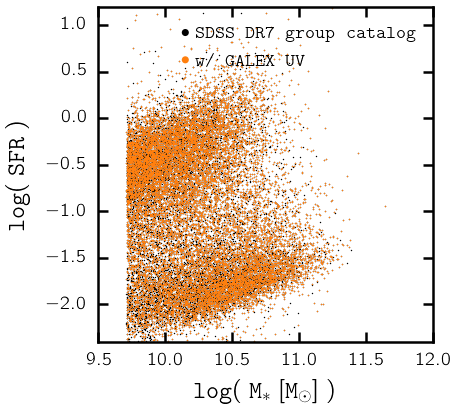

In [12]:
prettyplot()
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'], vagc['sfr'], c='k', lw=0, s=2, label='SDSS DR7 group catalog')
sub.scatter(vagc['mass'][m_vagc_nsa[has_UV]], vagc['sfr'][m_vagc_nsa[has_UV]], 
            c=pretty_colors[3], lw=0, s=2, label='w/ GALEX UV')

# x-axis
sub.set_xlim([9.5, 12.])
sub.set_xlabel('$\mathtt{log(\;M_*\;[M_\odot]\;)}$', fontsize=25, labelpad=15)

# y-axis
sub.set_ylim([-2.4, 1.2])
sub.set_ylabel('$\mathtt{log(\;SFR\;)}$', fontsize=25, labelpad=15)

sub.legend(loc='upper right', numpoints=1, scatterpoints=1, markerscale=5, handletextpad=-0.5)

No obvious bias. So lets proceed!
### How consistent are the derived $\mathcal{M}_*$ and SFR values

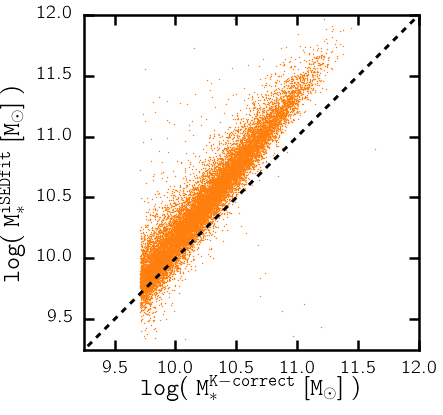

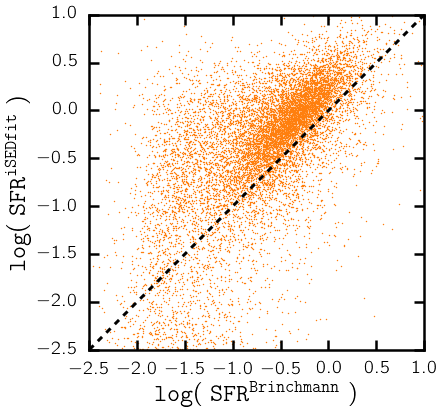

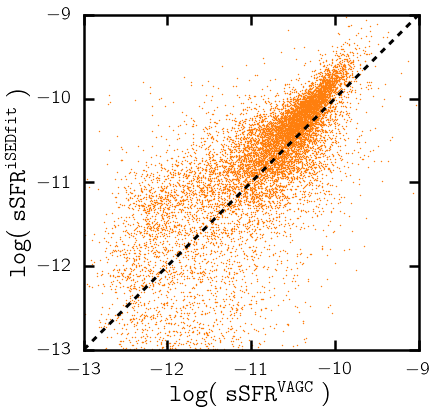

In [13]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'][m_vagc_nsa[has_UV]], vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV]], 
            c=pretty_colors[3], lw=0, s=2)
sub.plot([9., 12.], [9., 12.], lw=3, c='k', ls='--')
# x-axis 
sub.set_xlim([9.25, 12.])
sub.set_xlabel('$\mathtt{log(\;M_*^{K-correct}\;[M_\odot]\;)}$', fontsize=25)
# y-axis
sub.set_ylim([9.25, 12.])
sub.set_ylabel('$\mathtt{log(\;M_*^{iSEDfit}\;[M_\odot]\;)}$', fontsize=25)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['sfr'][m_vagc_nsa[has_UV]], vagc['isedfit_sfr_50'][m_vagc_nsa[has_UV]], 
            c=pretty_colors[3], lw=0, s=2)
sub.plot([-2.5, 1.], [-2.5, 1.], lw=3, c='k', ls='--')
# x-axis
sub.set_xlim([-2.5, 1.])
sub.set_xlabel('$\mathtt{log(\;SFR^{Brinchmann}\;)}$', fontsize=25)
# y-axis
sub.set_ylim([-2.5, 1.])
sub.set_ylabel('$\mathtt{log(\;SFR^{iSEDfit}\;)}$', fontsize=25)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['sfr'][m_vagc_nsa[has_UV]]-vagc['mass'][m_vagc_nsa[has_UV]], 
            vagc['isedfit_sfr_50'][m_vagc_nsa[has_UV]]-vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV]], 
            c=pretty_colors[3], lw=0, s=2)
sub.plot([-13., -9.], [-13., -9.], lw=3, c='k', ls='--')
# x-axis
sub.set_xlim([-13., -9.])
sub.set_xlabel('$\mathtt{log(\;sSFR^{VAGC}\;)}$', fontsize=25)
sub.set_xticks([-13., -12., -11., -10., -9.])
# y-axis
sub.set_ylim([-13, -9.])
sub.set_ylabel('$\mathtt{log(\;sSFR^{iSEDfit}\;)}$', fontsize=25)
sub.set_yticks([-13., -12., -11., -10., -9.])

SSFR for iSEDfit is discretized. Most likely because of the way iSEDfit finds the best-fit values based on a grid.

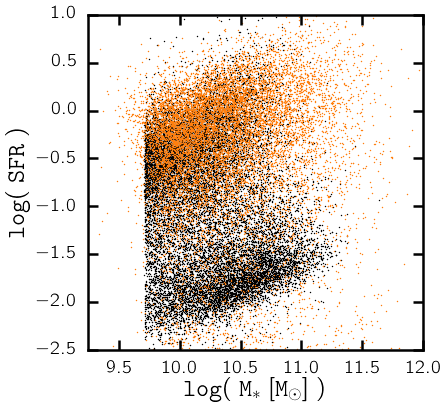

In [14]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'][m_vagc_nsa[has_UV]], vagc['sfr'][m_vagc_nsa[has_UV]], 
            c='k', lw=0, s=2)
sub.scatter(vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV]], vagc['isedfit_sfr_50'][m_vagc_nsa[has_UV]], 
            c=pretty_colors[3], lw=0, s=2)
# x-axis 
sub.set_xlim([9.25, 12.])
sub.set_xlabel('$\mathtt{log(\;M_*\;[M_\odot]\;)}$', fontsize=25)
# y-axis
sub.set_ylim([-2.5, 1.])
sub.set_ylabel('$\mathtt{log(\;SFR\;)}$', fontsize=25)

### $P(sSFR^{VAGC})$ vs $P(sSFR^{iSEDfit})$
in stellar mass bins of $\mathcal{M}_*^{K-correct}$, so we're looking at the same galaxies

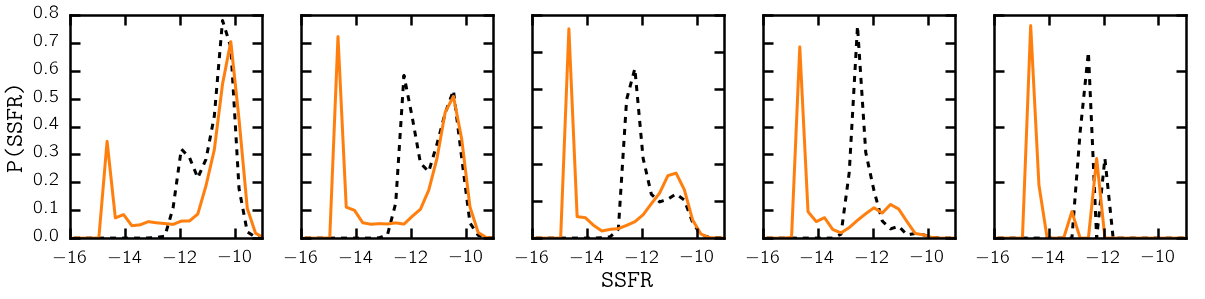

In [15]:
fig = plt.figure(figsize=(20,4))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3], [11.3, 11.7]]

for i_sub, mass_bin in enumerate(mass_bins): # loop through the mass bins
    # SDSS DR 7 Group catalog
    sub = fig.add_subplot(1, len(mass_bins), i_sub+1)
    in_massbin = np.where((vagc['mass'][m_vagc_nsa[has_UV]] >= mass_bin[0]) & 
                          (vagc['mass'][m_vagc_nsa[has_UV]] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['sfr'][m_vagc_nsa[has_UV[0][in_massbin]]] - vagc['mass'][m_vagc_nsa[has_UV[0][in_massbin]]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-16., -7.], bins=30, normed=True)    
        # P(ssfr) SDSS DR7 group catalog
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
        ssfrs = vagc['isedfit_sfr_50'][m_vagc_nsa[has_UV[0][in_massbin]]] - vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV[0][in_massbin]]]

        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-16., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
    sub.set_xlim([-16., -9.])
    sub.set_xticks([-16., -14., -12., -10.])
    #sub.set_ylim([0., 1.6])
    #sub.set_yticks([0., 0.5, 1., 1.5])
    if i_sub != 0: 
        sub.set_yticklabels([])
        
bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

The discrepancies in the quiescent peak is due to the fact that the Brinchmann sSFR have a higher lower limit. So lets impose the same lower bound and see what the P(SSFR)s look like!

In [16]:
def LogSSFR_Qpeak(mstar):
    return 0.4 * (mstar - 10.5) - 1.73 - mstar

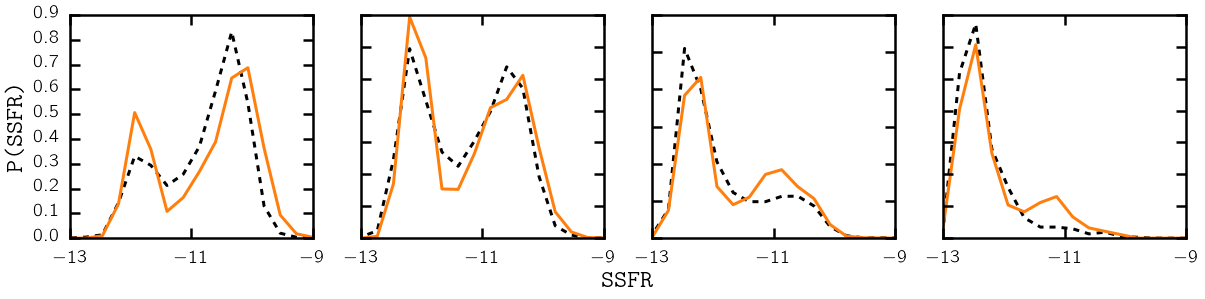

In [17]:
fig = plt.figure(figsize=(20,4))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3]]

for i_sub, mass_bin in enumerate(mass_bins): # loop through the mass bins
    # SDSS DR 7 Group catalog
    sub = fig.add_subplot(1, len(mass_bins), i_sub+1)
    in_massbin = np.where((vagc['mass'][m_vagc_nsa[has_UV]] >= mass_bin[0]) & 
                          (vagc['mass'][m_vagc_nsa[has_UV]] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['sfr'][m_vagc_nsa[has_UV[0][in_massbin]]] - vagc['mass'][m_vagc_nsa[has_UV[0][in_massbin]]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)    
        # P(ssfr) SDSS DR7 group catalog
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
        ssfrs = vagc['isedfit_sfr_50'][m_vagc_nsa[has_UV[0][in_massbin]]] - vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV[0][in_massbin]]]
        #ssfrs = vagc['isedfit_sfr_50'][m_vagc_nsa[has_UV[0][in_massbin]]] - vagc['mass'][m_vagc_nsa[has_UV[0][in_massbin]]]
        below_limit = np.where(ssfrs < LogSSFR_Qpeak((vagc['mass'][m_vagc_nsa[has_UV[0][in_massbin]]]))-0.18) 
        ssfrs[below_limit] = 0.18 * np.random.randn(len(below_limit[0])) + LogSSFR_Qpeak(
            (vagc['mass'][m_vagc_nsa[has_UV[0][in_massbin]]])[below_limit])
        
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
    sub.set_xlim([-13., -9.])
    sub.set_xticks([-13., -11., -9.])
    #sub.set_ylim([0., 1.6])
    #sub.set_yticks([0., 0.5, 1., 1.5])
    if i_sub != 0: 
        sub.set_yticklabels([])
        
bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

Some of these discrepancies may be caused by the different photometry in DR 8 versus DR 7. Lets try iSEDfit that uses DR7

In [18]:
jm_kcorr_file = ''.join([local_dir, 'mf_parent_sdss.fits.gz'])
jm_kcorr_dat = mrdfits(jm_kcorr_file)

moustakas_file = ''.join([local_dir, 'ised_parent_supergrid01_sdss.fits.gz'])
moustakas_dat = mrdfits(moustakas_file)

assert (np.abs(jm_kcorr_dat.zprimus - moustakas_dat.zobj)).max() == 0.

# save to dictionary
moustakas = {}
moustakas['ra'] = jm_kcorr_dat.ra
moustakas['dec'] = jm_kcorr_dat.dec
moustakas['z'] = moustakas_dat.zobj
moustakas['mass'] = moustakas_dat.mass_50
moustakas['sfr'] = moustakas_dat.sfr_50

(-20, 400)

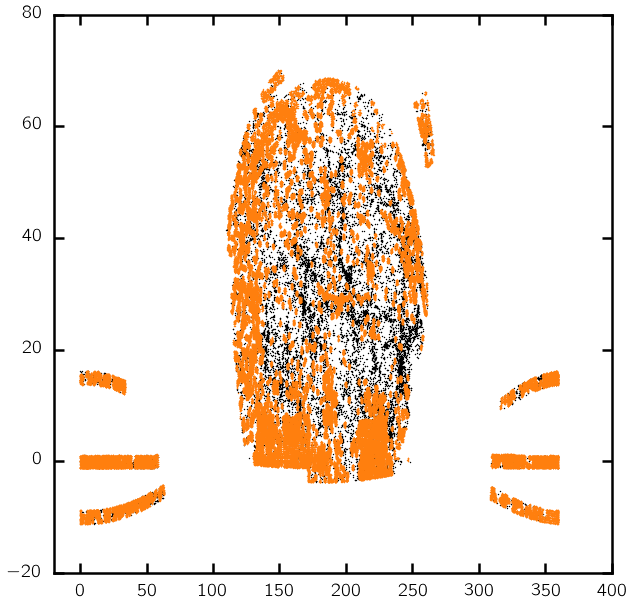

In [19]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.scatter(vagc['ra'], vagc['dec'], c='k', lw=0, s=2)
sub.scatter(moustakas['ra'], moustakas['dec'], c=pretty_colors[3], lw=0, s=2)
sub.set_xlim([-20, 400])

(0.0, 0.1)

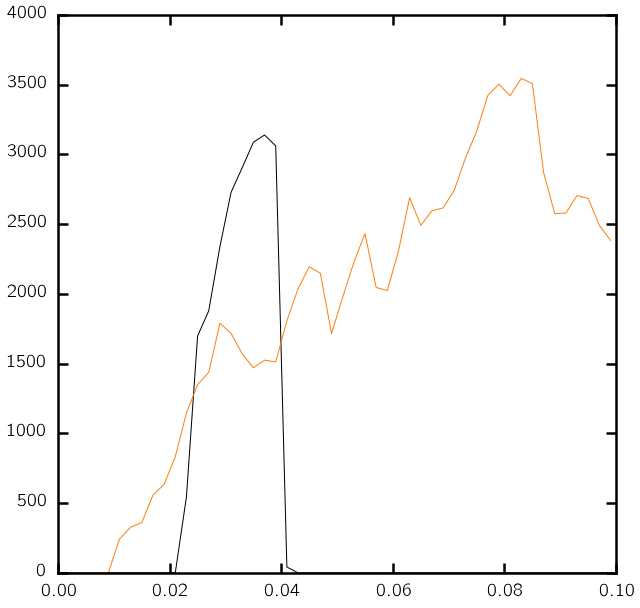

In [20]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)

pz, pz_bin_edges = np.histogram(vagc['z'], range=[0., 0.1], bins=50)
sub.plot(0.5*(pz_bin_edges[:-1]+pz_bin_edges[1:]), pz, color='k')

pz, pz_bin_edges = np.histogram(moustakas['z'], range=[0., 0.1], bins=50)
sub.plot(0.5*(pz_bin_edges[:-1]+pz_bin_edges[1:]), pz, color=pretty_colors[3])
sub.set_xlim([0., 0.1])

(9.0, 12.0)

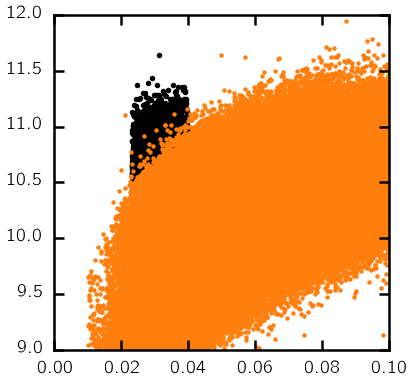

In [21]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['z'], vagc['mass'], c='k')
sub.scatter(moustakas['z'], moustakas['mass'], c=pretty_colors[3], lw=0)
sub.set_xlim([0., 0.1])
sub.set_ylim([9., 12.])

In [22]:
m_vagc_moust, m_moust_vagc, dd = spherematch(vagc['ra'], vagc['dec'], moustakas['ra'], moustakas['dec'], 0.0003)

In [23]:
print len(m_vagc_moust), ' matches out of ', len(vagc['ra'])

5554  matches out of  21423


(9.0, 12.0)

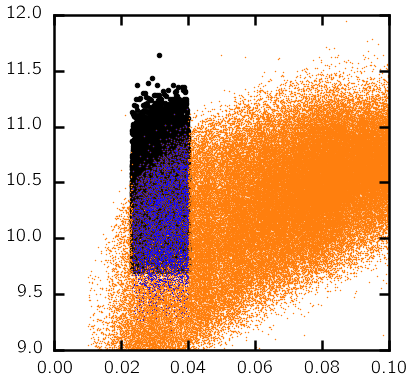

In [38]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['z'], vagc['mass'], c='k')
sub.scatter(moustakas['z'], moustakas['mass'], c=pretty_colors[3], lw=0, s=2)
sub.scatter(moustakas['z'][m_moust_vagc], moustakas['mass'][m_moust_vagc], c='b', lw=0, s=1)
sub.set_xlim([0., 0.1])
sub.set_ylim([9., 12.])

In [24]:
for key in ['mass', 'sfr']: 
    vagc['M2013_'+key] = np.repeat(-999., len(vagc['ra']))
    vagc['M2013_'+key][m_vagc_moust] = moustakas[key][m_moust_vagc]

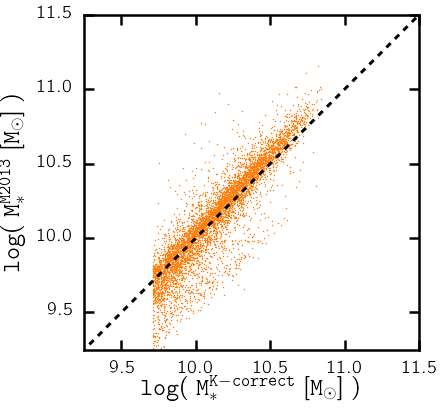

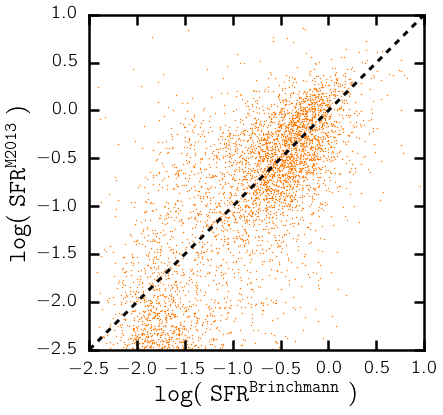

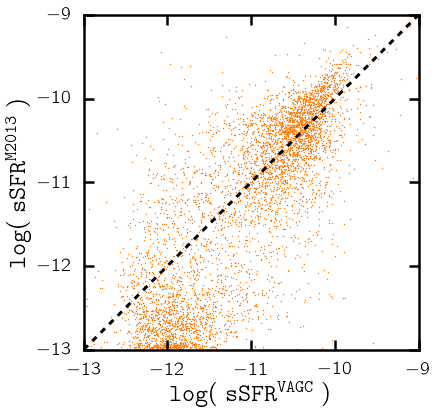

In [25]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'][m_vagc_moust], vagc['M2013_mass'][m_vagc_moust], c=pretty_colors[3], lw=0, s=2)
sub.plot([9., 12.], [9., 12.], lw=3, c='k', ls='--')
# x-axis 
sub.set_xlim([9.25, 11.5])
sub.set_xlabel('$\mathtt{log(\;M_*^{K-correct}\;[M_\odot]\;)}$', fontsize=25)
# y-axis
sub.set_ylim([9.25, 11.5])
sub.set_ylabel('$\mathtt{log(\;M_*^{M2013}\;[M_\odot]\;)}$', fontsize=25)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['sfr'][m_vagc_moust], vagc['M2013_sfr'][m_vagc_moust], 
            c=pretty_colors[3], lw=0, s=2)
sub.plot([-2.5, 1.], [-2.5, 1.], lw=3, c='k', ls='--')
# x-axis
sub.set_xlim([-2.5, 1.])
sub.set_xlabel('$\mathtt{log(\;SFR^{Brinchmann}\;)}$', fontsize=25)
# y-axis
sub.set_ylim([-2.5, 1.])
sub.set_ylabel('$\mathtt{log(\;SFR^{M2013}\;)}$', fontsize=25)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['sfr'][m_vagc_moust]-vagc['mass'][m_vagc_moust], 
            vagc['M2013_sfr'][m_vagc_moust]-vagc['M2013_mass'][m_vagc_moust],
            c=pretty_colors[3], lw=0, s=2)
sub.plot([-13., -9.], [-13., -9.], lw=3, c='k', ls='--')
# x-axis
sub.set_xlim([-13., -9.])
sub.set_xlabel('$\mathtt{log(\;sSFR^{VAGC}\;)}$', fontsize=25)
sub.set_xticks([-13., -12., -11., -10., -9.])
# y-axis
sub.set_ylim([-13, -9.])
sub.set_ylabel('$\mathtt{log(\;sSFR^{M2013}\;)}$', fontsize=25)
sub.set_yticks([-13., -12., -11., -10., -9.])

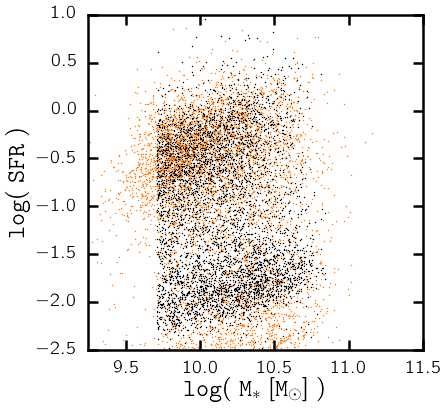

In [26]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'][m_vagc_moust], vagc['sfr'][m_vagc_moust], 
            c='k', lw=0, s=2)
sub.scatter(vagc['M2013_mass'][m_vagc_moust], vagc['M2013_sfr'][m_vagc_moust], 
            c=pretty_colors[3], lw=0, s=2)
# x-axis 
sub.set_xlim([9.25, 11.5])
sub.set_xlabel('$\mathtt{log(\;M_*\;[M_\odot]\;)}$', fontsize=25)
# y-axis
sub.set_ylim([-2.5, 1.])
sub.set_ylabel('$\mathtt{log(\;SFR\;)}$', fontsize=25)

### P(SSFR) comparison with *same* $\mathcal{M}_*^{K-correct}$ mass bins

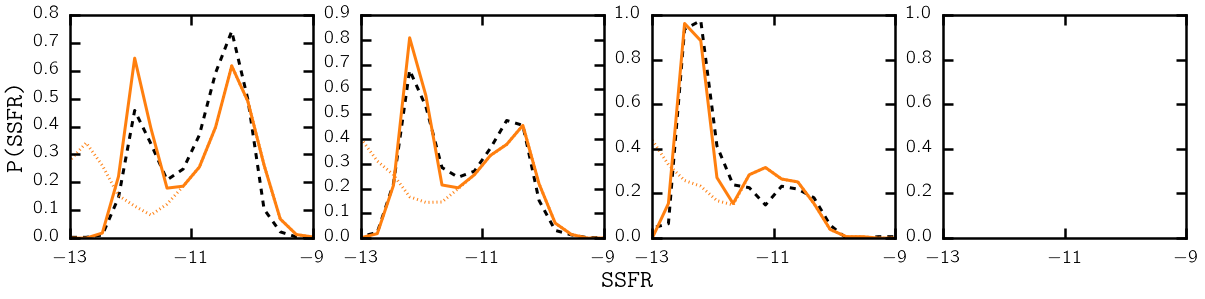

In [27]:
fig = plt.figure(figsize=(20,4))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3]]

for i_sub, mass_bin in enumerate(mass_bins): # loop through the mass bins
    # SDSS DR 7 Group catalog
    sub = fig.add_subplot(1, len(mass_bins), i_sub+1)
    in_massbin = np.where((vagc['mass'][m_vagc_moust] >= mass_bin[0]) & 
                          (vagc['mass'][m_vagc_moust] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['sfr'][m_vagc_moust[in_massbin]] - vagc['mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)    
        # P(ssfr) SDSS DR7 group catalog
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
        ssfrs = vagc['M2013_sfr'][m_vagc_moust[in_massbin]] - vagc['M2013_mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3], ls=':')

        below_limit = np.where(ssfrs < LogSSFR_Qpeak(0.5*np.sum(mass_bin))-0.18) 
        
        ssfrs[below_limit] = 0.18 * np.random.randn(len(below_limit[0])) + LogSSFR_Qpeak(#0.5*np.sum(mass_bin))
            (vagc['M2013_mass'][m_vagc_moust[in_massbin]])[below_limit])     
        
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
    sub.set_xlim([-13., -9.])
    sub.set_xticks([-13., -11., -9.])
    #sub.set_ylim([0., 1.6])
    #sub.set_yticks([0., 0.5, 1., 1.5])
        
bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

### P(SSFR) comparison with their own mass bins

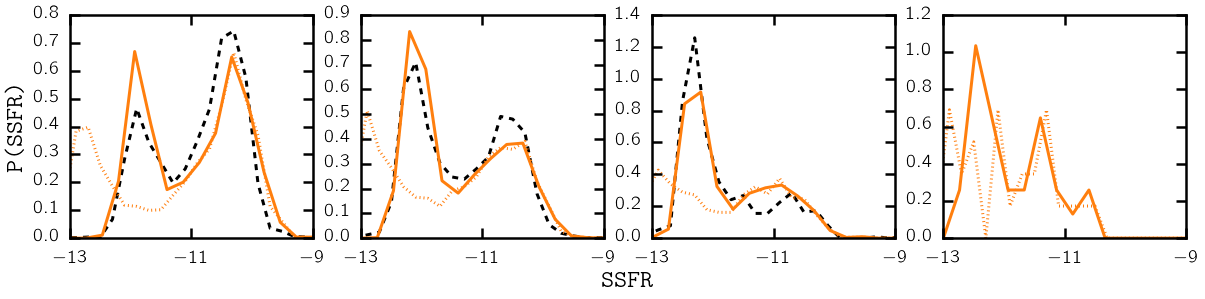

In [28]:
fig = plt.figure(figsize=(20,4))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

for i_sub, mass_bin in enumerate(mass_bins): # loop through the mass bins
    # SDSS DR 7 Group catalog
    sub = fig.add_subplot(1, len(mass_bins), i_sub+1)
    in_massbin = np.where((vagc['mass'][m_vagc_moust] >= mass_bin[0]) & 
                          (vagc['mass'][m_vagc_moust] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['sfr'][m_vagc_moust[in_massbin]] - vagc['mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=40, normed=True)    
        # P(ssfr) SDSS DR7 group catalog
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')

    in_massbin = np.where((vagc['M2013_mass'][m_vagc_moust] >= mass_bin[0]) & 
                          (vagc['M2013_mass'][m_vagc_moust] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['M2013_sfr'][m_vagc_moust[in_massbin]] - vagc['M2013_mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=40, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3], ls=':')
    
        below_limit = np.where(ssfrs < LogSSFR_Qpeak(vagc['M2013_mass'][m_vagc_moust[in_massbin]]) - 0.18)
        ssfrs[below_limit] = 0.18 * np.random.randn(len(below_limit[0])) + LogSSFR_Qpeak(vagc['M2013_mass'][m_vagc_moust[in_massbin]])[below_limit]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
    sub.set_xlim([-13., -9.])
    sub.set_xticks([-13., -11., -9.])
    #sub.set_ylim([0., 1.6])
    #sub.set_yticks([0., 0.5, 1., 1.5])
        
bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

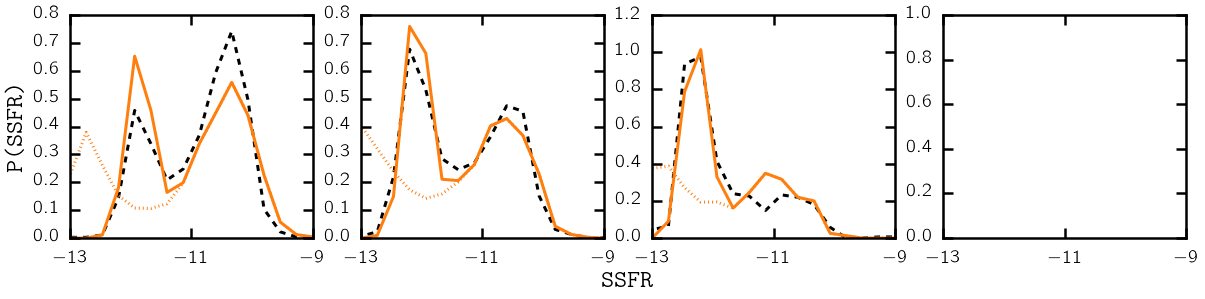

In [29]:
fig = plt.figure(figsize=(20,4))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3]]

for i_sub, mass_bin in enumerate(mass_bins): # loop through the mass bins
    # SDSS DR 7 Group catalog
    sub = fig.add_subplot(1, len(mass_bins), i_sub+1)
    in_massbin = np.where((vagc['mass'][m_vagc_moust] >= mass_bin[0]) & 
                          (vagc['mass'][m_vagc_moust] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['sfr'][m_vagc_moust[in_massbin]] - vagc['mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)    
        # P(ssfr) SDSS DR7 group catalog
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
        ssfrs = vagc['M2013_sfr'][m_vagc_moust[in_massbin]] - vagc['mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3], ls=':')

        below_limit = np.where(ssfrs < LogSSFR_Qpeak(0.5*np.sum(mass_bin))-0.18) 
        
        ssfrs[below_limit] = 0.18 * np.random.randn(len(below_limit[0])) + LogSSFR_Qpeak(#0.5*np.sum(mass_bin))
            (vagc['mass'][m_vagc_moust[in_massbin]])[below_limit])     
        
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-15., -7.], bins=30, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
    sub.set_xlim([-13., -9.])
    sub.set_xticks([-13., -11., -9.])
    #sub.set_ylim([0., 1.6])
    #sub.set_yticks([0., 0.5, 1., 1.5])
        
bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

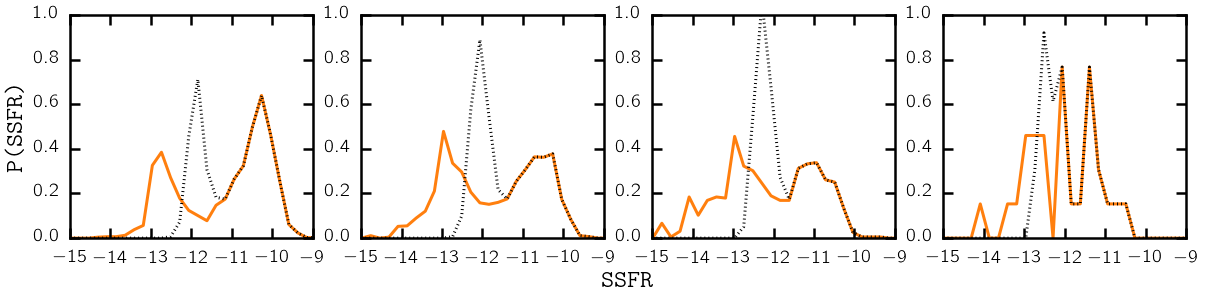

In [36]:
fig = plt.figure(figsize=(20,4))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3]]

for i_sub, mass_bin in enumerate(mass_bins): # loop through the mass bins
    # SDSS DR 7 Group catalog
    sub = fig.add_subplot(1, len(mass_bins), i_sub+1)
    in_massbin = np.where((vagc['M2013_mass'][m_vagc_moust] >= mass_bin[0]) & 
                          (vagc['M2013_mass'][m_vagc_moust] < mass_bin[1]))
        
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['M2013_sfr'][m_vagc_moust[in_massbin]] - vagc['M2013_mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-16., -7.], bins=40, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])       
        
        below_limit = np.where(ssfrs < LogSSFR_Qpeak(0.5*np.sum(mass_bin))-0.18) 
        
        ssfrs[below_limit] = 0.18 * np.random.randn(len(below_limit[0])) + LogSSFR_Qpeak(#0.5*np.sum(mass_bin))
            (vagc['mass'][m_vagc_moust[in_massbin]])[below_limit])     
        
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-16., -7.], bins=40, normed=True)
        # P(ssfr) NSA iSEDfit
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c='k', ls=':')
    sub.set_xlim([-15., -9.])
    #sub.set_xticks([-13., -11., -9.])
    sub.set_ylim([0., 1.])
    #sub.set_yticks([0., 0.5, 1., 1.5])
        
bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

### Now lets make a figure worthy of publishing

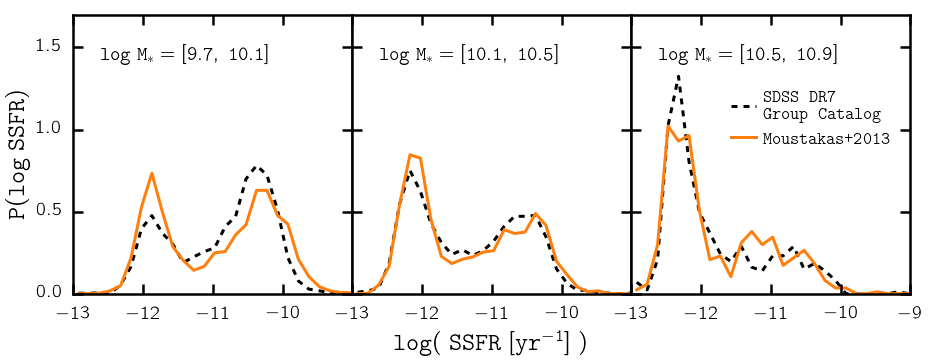

In [113]:
fig = plt.figure(figsize=(15, 5))
bkgd = fig.add_subplot(111, frameon=False)

panel_mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9]]#, [10.9, 11.3]]
for i_m, mass_bin in enumerate(panel_mass_bins):
    sub = fig.add_subplot(1, 3, i_m+1)
    
    in_massbin = np.where((vagc['mass'][m_vagc_moust] >= mass_bin[0]) & 
                          (vagc['mass'][m_vagc_moust] < mass_bin[1]))
    
    if len(in_massbin[0]) > 0: 
        ssfrs = vagc['sfr'][m_vagc_moust[in_massbin]] - vagc['mass'][m_vagc_moust[in_massbin]]
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-13., -7.], bins=40, normed=True)    
        # P(ssfr) SDSS DR7 group catalog
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, 
                 lw=3, ls='--', c='k', label='SDSS DR7\nGroup Catalog')

        ssfrs = vagc['M2013_sfr'][m_vagc_moust[in_massbin]] - vagc['M2013_mass'][m_vagc_moust[in_massbin]]
    
        below_limit = np.where(ssfrs < LogSSFR_Qpeak(vagc['M2013_mass'][m_vagc_moust[in_massbin]]) - 0.18)
        ssfrs[below_limit] = 0.18 * np.random.randn(len(below_limit[0])) + LogSSFR_Qpeak(
            (vagc['M2013_mass'][m_vagc_moust[in_massbin]])[below_limit])         
        p_ssfr, ssfr_bin_edge = np.histogram(ssfrs, range=[-13., -7.], bins=40, normed=True)
        sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, 
                 lw=3, c=pretty_colors[3], label='Moustakas+2013')

    massbin_str = ''.join([r'$\mathtt{log \; M_{*} = [', str(mass_bin[0]), ',\;', str(mass_bin[1]), ']}$'])
    sub.text(-12.6, 1.4, massbin_str, fontsize=20)

    # x-axis
    if i_m == len(panel_mass_bins)-1:
        sub.set_xticks([-13, -12, -11, -10, -9])
    else:
        sub.set_xticks([-13, -12, -11, -10])
    sub.set_xlim([-13., -9.])
    # y-axis
    sub.set_ylim([0.0, 1.7])
    sub.set_yticks([0.0, 0.5, 1.0, 1.5])
    if i_m == 0:
        sub.set_ylabel(r'$\mathtt{P(log \; SSFR)}$', fontsize=25)
    else:
        sub.set_yticklabels([])
ax = plt.gca()
leg = sub.legend(bbox_to_anchor=(-8.65, 1.5), loc='upper right', prop={'size': 17.5}, borderpad=2,
                bbox_transform=ax.transData, handletextpad=0.1)    
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
bkgd.set_xlabel(r'$\mathtt{log(\; SSFR \;[yr^{-1}]\;)}$', fontsize=25, labelpad=10)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig('../tex/figs/Pssfr_comparison.pdf', bbox_inches='tight')

## Investigating the stellar mass discrepancy
Improved background subtracting in DR8 makes increase stellar masses for massive galaxies. How would that change impact $\tau_Q(\mathcal{M}_*)$

[ 1.20686644 -1.91208969]


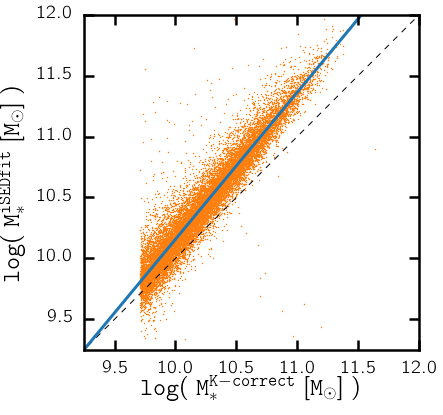

In [108]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['mass'][m_vagc_nsa[has_UV]], vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV]], 
            c=pretty_colors[3], lw=0, s=2)
sub.plot([9., 12.], [9., 12.], lw=1, c='k', ls='--')
# plot best-fit line
coeff = np.polyfit(vagc['mass'][m_vagc_nsa[has_UV]], vagc['isedfit_mstar_50'][m_vagc_nsa[has_UV]], 1)
print coeff
sub.plot(np.arange(9., 12.1, 0.1), coeff[1]+coeff[0]*np.arange(9., 12.1, 0.1), lw=3,c=pretty_colors[1])

# x-axis 
sub.set_xlim([9.25, 12.])
sub.set_xlabel('$\mathtt{log(\;M_*^{K-correct}\;[M_\odot]\;)}$', fontsize=25)
# y-axis
sub.set_ylim([9.25, 12.])
sub.set_ylabel('$\mathtt{log(\;M_*^{iSEDfit}\;[M_\odot]\;)}$', fontsize=25)
